In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
img = cv2.imread("imori.jpg")

(-0.5, 127.5, 127.5, -0.5)

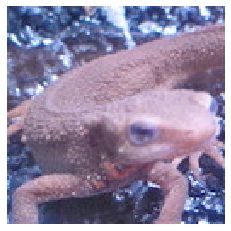

In [4]:
plt.imshow(img[:,:,::-1])
plt.axis("off")

## 5. HSV変換

rgb -> hsv
```bash
Max = max(R,G,B)
Min = min(R,G,B)

H =  { 0                            (if Min=Max)
       60 x (G-R) / (Max-Min) + 60  (if Min=B)
       60 x (B-G) / (Max-Min) + 180 (if Min=R)
       60 x (R-B) / (Max-Min) + 300 (if Min=G)
       
V = Max

S = Max - Min
```

In [133]:
norm = img / 255.

In [134]:
b = norm[:,:,0]
g = norm[:,:,1]
r = norm[:,:,2]

In [135]:
norm.shape

(128, 128, 3)

In [136]:
v_max = np.max(norm, axis=-1)
v_min = np.min(norm, axis=-1)

In [137]:
V = v_max
S = v_max - v_min

In [138]:
H = np.zeros(norm.shape[:2])

In [139]:
H = np.where(v_min == b, ((60 * (g - r)) / S) + 60, H)
H = np.where(v_min == r, ((60 * (b - g)) / S) + 180, H)
H = np.where(v_min == g, ((60 * (r - b)) / S) + 300, H)

In [144]:
H = (H + 180) % 360  # 0 <= H < 360

hsv -> rgb
```bash
C = S

H' = H / 60

X = C (1 - |H' mod 2 - 1|)

(R,G,B) = (V - C) (1,1,1) + { (0, 0, 0)  (if H is undefined)
                              (C, X, 0)  (if 0 <= H' < 1)
                              (X, C, 0)  (if 1 <= H' < 2)
                              (0, C, X)  (if 2 <= H' < 3)
                              (0, X, C)  (if 3 <= H' < 4)
                              (X, 0, C)  (if 4 <= H' < 5)
                              (C, 0, X)  (if 5 <= H' < 6)
```

In [145]:
C = S
H_d = H / 60
X = C * (1 - abs((H_d % 2 - 1)))

In [146]:
out = np.zeros(norm.shape)

In [147]:
out += np.expand_dims((V - C), axis=-1).dot(np.ones((1, 3)))

In [148]:
Z = np.zeros_like(C)

In [149]:
out[((0 <= H_d) & (H_d < 1)),:] += np.stack((C, X, Z), axis=-1)[((0 <= H_d) & (H_d < 1))]
out[((1 <= H_d) & (H_d < 2)),:] += np.stack((X, C, Z), axis=-1)[((1 <= H_d) & (H_d < 2))]
out[((2 <= H_d) & (H_d < 3)),:] += np.stack((Z, C, X), axis=-1)[((2 <= H_d) & (H_d < 3))]
out[((3 <= H_d) & (H_d < 4)),:] += np.stack((Z, X, C), axis=-1)[((3 <= H_d) & (H_d < 4))]
out[((4 <= H_d) & (H_d < 5)),:] += np.stack((X, Z, C), axis=-1)[((4 <= H_d) & (H_d < 5))]
out[((5 <= H_d) & (H_d < 6)),:] += np.stack((C, Z, X), axis=-1)[((5 <= H_d) & (H_d < 6))]

In [150]:
out = (out * 255).astype(np.uint8)

(-0.5, 127.5, 127.5, -0.5)

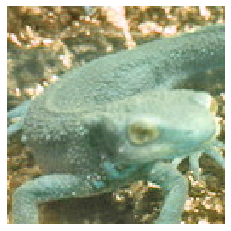

In [152]:
plt.imshow(out)
plt.axis("off")

## 6. 減色処理

ここでは画像の値を256^3から4^3、すなわちR,G,B in {32, 96, 160, 224}の各4値に減色せよ。
これは量子化操作である。
各値に関して、以下の様に定義する。

```bash
val = {  32  (  0 <= val <  64)
         96  ( 64 <= val < 128)
        160  (128 <= val < 192)
        224  (192 <= val < 256)
```

In [153]:
out = img.copy()

In [154]:
out[np.where(out < 64)] = 32
out[np.where((64 <= out) & (out < 128))] = 96
out[np.where((128 <= out) & (out < 192))] = 160
out[np.where(192 <= out)] = 224

(-0.5, 127.5, 127.5, -0.5)

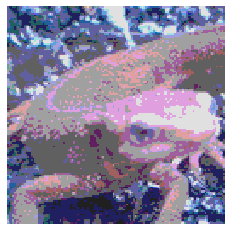

In [155]:
plt.imshow(out[:,:,::-1])
plt.axis("off")

## 7. 平均プーリング

ここでは画像をグリッド分割(ある固定長の領域に分ける)し、かく領域内(セル)の平均値でその領域内の値を埋める。
このようにグリッド分割し、その領域内の代表値を求める操作は**Pooling(プーリング)** と呼ばれる。
これらプーリング操作は**CNN(Convolutional Neural Network)** において重要な役割を持つ。

これは次式で定義される。

```bash
v = 1/|R| * Sum_{i in R} v_i
```

ここではimori.jpgは128x128なので、8x8にグリッド分割し、平均プーリングせよ。

In [238]:
w = 8
r = img[:,:,2]
g = img[:,:,1]
b = img[:,:,0]

pool = np.array([(b[i * w:(i+1) * w,j * w:(j+1) * w].mean(), 
                  g[i * w:(i+1) * w,j * w:(j+1) * w].mean(),
                  r[i * w:(i+1) * w,j * w:(j+1) * w].mean())
                 for i in range(img.shape[0]//w) for j in range(img.shape[1]//w)])

In [239]:
pool = pool.reshape((128//8, 128//8, 3)).astype(np.uint8)

(-0.5, 15.5, 15.5, -0.5)

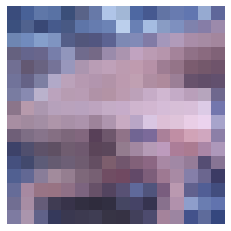

In [240]:
plt.imshow(pool[:,:,::-1])
plt.axis("off")

## 8. Maxプーリング

In [241]:
w = 8
r = img[:,:,2]
g = img[:,:,1]
b = img[:,:,0]

pool = np.array([(b[i * w:(i+1) * w,j * w:(j+1) * w].max(), 
                  g[i * w:(i+1) * w,j * w:(j+1) * w].max(),
                  r[i * w:(i+1) * w,j * w:(j+1) * w].max())
                 for i in range(img.shape[0]//w) for j in range(img.shape[1]//w)])

In [242]:
pool = pool.reshape((128//8, 128//8, 3)).astype(np.uint8)

(-0.5, 15.5, 15.5, -0.5)

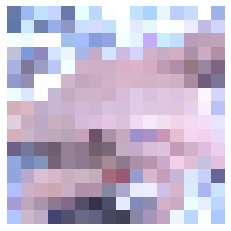

In [243]:
plt.imshow(pool[:,:,::-1])
plt.axis("off")

## 9. ガウシアンフィルタ

ガウシアンフィルタ(3x3、標準偏差1.3)を実装し、*imori_noise.jpg*のノイズを除去せよ。

ガウシアンフィルタとは画像の**平滑化**（滑らかにする）を行うフィルタの一種であり、**ノイズ除去**にも使われる。

ノイズ除去には他にも、メディアンフィルタ(Q.10)、平滑化フィルタ(Q.11)、LoGフィルタ(Q.19)などがある。

ガウシアンフィルタは注目画素の周辺画素を、ガウス分布による重み付けで平滑化し、次式で定義される。
このような重みは**カーネル**や**フィルタ**と呼ばれる。

ただし、画像の端はこのままではフィルタリングできないため、画素が足りない部分は0で埋める。これを**0パディング**と呼ぶ。
かつ、重みは正規化する。(sum g = 1)

```bash
重み g(x,y,s) = 1/ (s*sqrt(2 * pi)) * exp( - (x^2 + y^2) / (2*s^2))
標準偏差s = 1.3による8近傍ガウシアンフィルタは
            1 2 1
K =  1/16 [ 2 4 2 ]
            1 2 1
```

In [5]:
noise = cv2.imread("imori_noise.jpg")

(-0.5, 127.5, 127.5, -0.5)

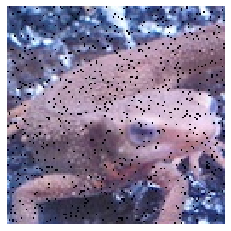

In [6]:
plt.imshow(noise[:,:,::-1])
plt.axis("off")

In [132]:
K_size = 3
pad = K_size // 2
K = np.zeros((K_size, K_size), dtype=np.float)
sigma = 1.3

for x in range(-pad, -pad + K_size):
    for y in range(-pad, -pad + K_size):
        K[x + pad, y + pad] = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x**2 + y**2) / (2 * (sigma**2)))
        
K /= K.sum()

In [133]:
# K = 1/16 * np.array(([1,2,1],[2,4,2],[1,2,1]))

In [134]:
denoised = np.pad(noise, ((pad,pad),(pad,pad),(0,0)))

In [135]:
tmp = denoised.copy()

In [136]:
for i in range(noise.shape[0]):
    for j in range(noise.shape[1]):
        for c in range(noise.shape[2]):
            denoised[pad+i,pad+j,c] = (tmp[i:i+K.shape[0],j:j+K.shape[1],c] * K).sum()
denoised = denoised[pad:-pad,pad:-pad].astype(np.uint8)

(-0.5, 127.5, 127.5, -0.5)

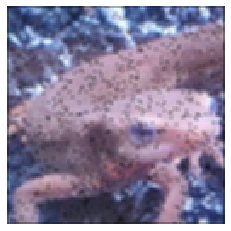

In [137]:
plt.imshow(denoised[:,:,::-1])
plt.axis("off")

## 10. メディアンフィルタ

メディアンフィルタ(3x3)を実装し、*imori_noise.jpg*のノイズを除去せよ。

メディアンフィルタとは画像の平滑化を行うフィルタの一種である。

これは注目画素の3x3の領域内の、メディアン値(中央値)を出力するフィルタである。
これもゼロパディングせよ。

In [127]:
K_size = 3
pad = K_size // 2

In [140]:
denoised = np.pad(noise, ((pad,pad), (pad,pad), (0,0)))
tmp = denoised.copy()

In [141]:
for x in range(noise.shape[0]):
    for y in range(noise.shape[1]):
        for c in range(noise.shape[2]):
            denoised[x+pad,y+pad,c] = np.median(tmp[x:x+K_size,y:y+K_size,c])
            
denoised = denoised[pad:-pad,pad:-pad].astype(np.uint8)

(-0.5, 127.5, 127.5, -0.5)

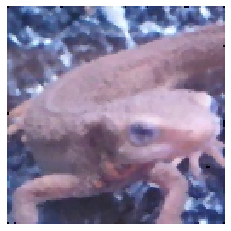

In [142]:
plt.imshow(denoised[:,:,::-1])
plt.axis("off")